### LSTM-Daily

(826, 1)
(207, 1)


/var/folders/p0/kb961x5d6wd79gfp2h6t_8500000gn/T/ipykernel_87268/1699450248.py:47: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(testX,testY))
2022-06-12 20:14:50.630543: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/6
83/83 [==============================] - 3s 10ms/step - loss: 0.0684 - val_loss: 0.0900
Epoch 2/6
83/83 [==============================] - 0s 3ms/step - loss: 0.0487 - val_loss: 0.0886
Epoch 3/6
83/83 [==============================] - 0s 3ms/step - loss: 0.0479 - val_loss: 0.0862
Epoch 4/6
83/83 [==============================] - 0s 3ms/step - loss: 0.0474 - val_loss: 0.0844
Epoch 5/6
83/83 [==============================] - 0s 3ms/step - loss: 0.0466 - val_loss: 0.0779
Epoch 6/6
83/83 [==============================] - 0s 1ms/step - loss: 0.0307
Epoch 1/6
83/83 [==============================] - 3s 10ms/step - loss: 0.0434 - val_loss: 0.1142
Epoch 2/6
83/83 [==============================] - 0s 3ms/step - loss: 0.0320 - val_loss: 0.1093
Epoch 3/6
83/83 [==============================] - 0s 3ms/step - loss: 0.0313 - val_loss: 0.1117
Epoch 4/6
83/83 [==============================] - 0s 3ms/step - loss: 0.0310 - val_loss: 0.1102
Epoch 5/6
83/83 [==============================

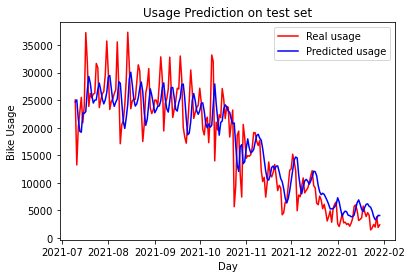

31.446559379993687


NameError: name '以多少预测' is not defined

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
df=pd.read_csv("day_result.csv",parse_dates=["started_at_day"],index_col=[0])
df.head()
a = df.groupby(['started_at_day']).agg('started_at').sum()
result = pd.DataFrame(a)
orig = result[-30:]
result = result.iloc[:-30]
#后20%用作测试
test_split=round(len(result)*0.20)
test_split
df_for_training=result[:-207]
df_for_testing=result[-207:]
print(df_for_training.shape)
print(df_for_testing.shape)
#标准化到0-1
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_testing_scaled=scaler.transform(df_for_testing)
#把时间序列编程监督数据集，n_past是用过去多少天进行预测，先选择3天
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)

trainX,trainY=createXY(df_for_training_scaled,3)
testX,testY=createXY(df_for_testing_scaled,3)
#构建LSTM-RNN时间序列模型
def build_model(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(32,return_sequences=True,input_shape=(3,1)))
    grid_model.add(LSTM(16))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1,activation = 'linear'))
    grid_model.compile(loss = 'mse',optimizer = optimizer)
    return grid_model 
grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(testX,testY))

parameters = {'batch_size' : [5,10,15,20],
              'epochs' : [6,8,10],
              'optimizer' : ['SGD','adam','Adadelta'] }

grid_search  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            cv = 2)
#找超参数
grid_search = grid_search.fit(trainX,trainY)
grid_search.best_params_
my_model=grid_search.best_estimator_.model
prediction=my_model.predict(testX)
pred = scaler.inverse_transform(prediction)
original = df_for_testing[3:]
a = pd.date_range(start='20210710', end='20220129')
pred = pd.DataFrame(pred, index = a)
plt.plot(original, color = 'red', label = 'Real usage')
plt.plot(pred, color = 'blue', label = 'Predicted usage')
plt.title('Usage Prediction on test set')
plt.xlabel('Day')
plt.ylabel('Bike Usage')
plt.legend()
plt.show()
def mape(y_true, y_pred):
    n = len(y_true)
    mape = sum(np.abs((y_true - y_pred)/y_true))/n*100
    return mape
real = []
predic = []
for i in range(len(original['started_at'])):
    real.append(original['started_at'][i])
    predic.append(pred[0][i])
print(mape(np.array(real),np.array(predic)))
original['started_at'][1]
timesteps=3
predict_steps=1
length = 30
def create_dataset(dataset, timesteps,predict_size):#构造数据集
    datax=[]#构造x
    datay=[]#构造y
    for each in range(len(dataset)-timesteps - predict_steps):
        x = dataset[each:each+timesteps,0]
        y = dataset[each+timesteps:each+timesteps+predict_steps,0]
        datax.append(x)
        datay.append(y)
    return datax, datay
predict_xlist = []#添加预测x列表
predict_y = []#添加预测y列表
predict_xlist.extend(df_for_testing_scaled[df_for_testing_scaled.shape[0]-timesteps:df_for_testing_scaled.shape[0],0].tolist())#已经存在的最后timesteps个数据添加进列表，预测新值(比如已经有的数据从1,2,3到288。现在要预测后面的数据，所以将216到288的72个数据添加到列表中，预测新的值即288以后的数据）
while len(predict_y) < length:
    predictx = np.array(predict_xlist[-timesteps:])#从最新的predict_xlist取出timesteps个数据，预测新的predict_steps个数据（因为每次预测的y会添加到predict_xlist列表中，为了预测将来的值，所以每次构造的x要取这个列表中最后的timesteps个数据词啊性）
    predictx = np.reshape(predictx,(1,timesteps,1))#变换格式，适应LSTM模型
    #预测新值
    lstm_predict = my_model.predict(predictx)
    #predict_list.append(train_predict)#新值y添加进列表，做x
    #滚动预测
    #print("lstm_predict"),print(lstm_predict[0])
    predict_xlist.extend(lstm_predict[0])#将新预测出来的predict_steps个数据，加入predict_xlist列表，用于下次预测
    # invert
    lstm_predict = scaler.inverse_transform(lstm_predict)
    predict_y.extend(lstm_predict[0])#预测的结果y，每次预测的12个数据，添加进去，直到预测288个为止
predict_y
b = pd.date_range(start='20220130', end='20220228')
predict_y = pd.DataFrame(predict_y, index = b)
plt.plot(orig, color = 'red', label = 'Real usage')
plt.plot(predict_y, color = 'blue', label = 'Predicted usage')
plt.title('Usage Prediction')
plt.xlabel('Day')
plt.ylabel('Bike Usage')
plt.legend()
plt.show()
df_3_days = result.iloc[-3:,:]
test = orig
test.drop('started_at',axis=1)
test["started_at"]=0
old_scaled_array=scaler.transform(df_3_days)
new_scaled_array=scaler.transform(test)
new_scaled_df=pd.DataFrame(new_scaled_array)
new_scaled_df.iloc[:,0]=np.nan
full_df=pd.concat([pd.DataFrame(old_scaled_array),new_scaled_df]).reset_index().drop(["index"],axis=1)
full_df_scaled_array=full_df.values
all_data=[]
time_step=3
for i in range(time_step,len(full_df_scaled_array)):
    data_x=[]
    data_x.append(
     full_df_scaled_array[i-time_step :i , 0:full_df_scaled_array.shape[1]])
    data_x=np.array(data_x)
    prediction=my_model.predict(data_x)
    all_data.append(prediction)
    full_df.iloc[i,0]=prediction
new_array=np.array(all_data)
new_array=new_array.reshape(-1,1)
y_pred_future_30_days = scaler.inverse_transform(new_array)
print(y_pred_future_30_days)


#### LSTM Hourly recursive

In [139]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
df=pd.read_csv("filled_hourly_agg.csv",parse_dates=["day-hour-time"],index_col=[0])
df.head()
raw = pd.DataFrame(df, columns = ['started_at'])
contain = pd.DataFrame(df, columns = ['day_of_week_start','started_at'])
order = ['started_at','day_of_week_start']
contain = contain[order]
#用最后5000小时的数据；raw是不加特征，contain是加特征
raw = raw.iloc[-5000:-168]
orig = contain.iloc[-168:]
contain = contain.iloc[-5000:-168]
#5000中的最后1000作为测试集
test_split=round(len(raw)*0.20)
test_split
r_train = raw[:-966]
r_test = raw[-966:]
c_train = contain[:-966]
c_test = contain[-966:]
#标准化数据
scaler = MinMaxScaler(feature_range=(0,1))
r_train_scaled = scaler.fit_transform(r_train)
r_test_scaled = scaler.fit_transform(r_test)
c_train_scaled = scaler.fit_transform(c_train)
c_test_scaled = scaler.fit_transform(c_test)
#分训练和测试集，用前12个小时预测第13个小时
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)

r_trainX,r_trainY=createXY(r_train_scaled,12)
r_testX,r_testY=createXY(r_test_scaled,12)
c_trainX,c_trainY=createXY(c_train_scaled,12)
c_testX,c_testY=createXY(c_test_scaled,12)
#model1是不加特征的数据，输入的维度第三行input_shape是12*1的
def build_model1(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(32,return_sequences=True,input_shape=(12,1)))
    grid_model.add(LSTM(16))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1,activation = 'linear'))
    grid_model.compile(loss = 'mse',optimizer = optimizer)
    return grid_model 
grid_model = KerasRegressor(build_fn=build_model1,verbose=1,validation_data=(r_testX,r_testY))

parameters = {'batch_size' : [10,25,50.100],
              'epochs' : [6,8,10],
              'optimizer' : ['SGD','adam','Adadelta'] }

grid_search1  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            cv = 2)
grid_search1 = grid_search1.fit(r_trainX,r_trainY)
#model2是加特征的数据，输入的维度是12*2的，第2列是星期几的状态变量
def build_model2(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(32,return_sequences=True,input_shape=(12,2)))
    grid_model.add(LSTM(16))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1,activation = 'linear'))
    grid_model.compile(loss = 'mse',optimizer = optimizer)
    return grid_model 
grid_model = KerasRegressor(build_fn=build_model2,verbose=1,validation_data=(c_testX,c_testY))

parameters = {'batch_size' : [10,25,50.100],
              'epochs' : [6,8,10],
              'optimizer' : ['SGD','adam','Adadelta'] }

grid_search2  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            cv = 2)
grid_search2 = grid_search2.fit(c_trainX,c_trainY)
#用grid_search找到两个模型的最好参数
my_model1=grid_search1.best_estimator_.model
my_model2=grid_search2.best_estimator_.model
#分别进行预测
prediction1=my_model1.predict(r_testX)
prediction2=my_model2.predict(c_testX)
#把标准化的数据还原回来
prediction_copies_array1 = np.repeat(prediction1, 2, axis=-1)
pred1=scaler.inverse_transform(np.reshape(prediction_copies_array1,(len(prediction1),2)))[:,0]
prediction_copies_array2 = np.repeat(prediction2, 2, axis=-1)
pred2=scaler.inverse_transform(np.reshape(prediction_copies_array2,(len(prediction2),2)))[:,0]
original_copies_array = np.repeat(r_testY,2, axis=-1)
original=scaler.inverse_transform(np.reshape(original_copies_array,(len(r_testY),2)))[:,0]
plt.plot(original[-24:], color = 'red', label = 'Real usage')
plt.plot(pred1[-24:], color = 'blue', label = 'Predicted usage without features')
plt.plot(pred2[-24:], color = 'green', label = 'Predicted usage with features')
plt.title('Usage Prediction on test set')
plt.xlabel('Hour')
plt.ylabel('Bike Usage')
plt.legend()
plt.show()
def mape(y_true, y_pred):
    n = len(y_true)
    mape = sum(np.abs((y_true - y_pred)/y_true))/n*100
    return mape
print('MAPE',mape(original,pred1))
plt.plot(original[-24:], color = 'red', label = 'Real usage')
plt.plot(pred2[-24:], color = 'green', label = 'Predicted usage with features')
plt.title('Usage Prediction on test set')
plt.xlabel('Time')
plt.ylabel('Bike Usage')
plt.legend()
plt.show()
print('MAPE',mape(original,pred2))
def create_dataset(dataset, timesteps,predict_size):#构造数据集
    datax=[]#构造x
    datay=[]#构造y
    for each in range(len(dataset)-timesteps - predict_steps):
        x = dataset[each:each+timesteps,0]
        y = dataset[each+timesteps:each+timesteps+predict_steps,0]
        datax.append(x)
        datay.append(y)
    return datax, datay#np.array(datax),np.array(datay)
timesteps=6
predict_steps=168
length=168
predict_xlist = []#添加预测x列表
predict_y = []#添加预测y列表
predict_xlist.extend(c_test_scaled[c_test_scaled.shape[0]-timesteps:c_test_scaled.shape[0],0].tolist())#已经存在的最后timesteps个数据添加进列表，预测新值(比如已经有的数据从1,2,3到288。现在要预测后面的数据，所以将216到288的72个数据添加到列表中，预测新的值即288以后的数据）
while len(predict_y) < length:
    predictx = np.array(predict_xlist[-timesteps:])#从最新的predict_xlist取出timesteps个数据，预测新的predict_steps个数据（因为每次预测的y会添加到predict_xlist列表中，为了预测将来的值，所以每次构造的x要取这个列表中最后的timesteps个数据词啊性）
    predictx = np.reshape(predictx,(1,timesteps,1))#变换格式，适应LSTM模型
    #预测新值
    lstm_predict = my_model2.predict(predictx)
    #predict_list.append(train_predict)#新值y添加进列表，做x
    #滚动预测
    #print("lstm_predict"),print(lstm_predict[0])
    predict_xlist.extend(lstm_predict[0])#将新预测出来的predict_steps个数据，加入predict_xlist列表，用于下次预测
    # invert
    prediction_copies_array = np.repeat(lstm_predict, 2, axis=-1)
    lstm_predict = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(lstm_predict),2)))[:,0]
    predict_y.extend(lstm_predict[0])#预测的结果y，每次预测的12个数据，添加进去，直到预测288个为止
df_6_hours = contain.iloc[-6:,:]
df_6_hours
test = orig
test.drop('started_at',axis=1)
test["started_at"]=0
test=test[["started_at","day_of_week_start"]]
old_scaled_array=scaler.transform(df_6_hours)
new_scaled_array=scaler.transform(test)
new_scaled_df=pd.DataFrame(new_scaled_array)
new_scaled_df.iloc[:,0]=np.nan
full_df=pd.concat([pd.DataFrame(old_scaled_array),new_scaled_df]).reset_index().drop(["index"],axis=1)
full_df
full_df_scaled_array=full_df.values
all_data=[]
time_step=6
for i in range(time_step,len(full_df_scaled_array)):
    data_x=[]
    data_x.append(
     full_df_scaled_array[i-time_step :i , 0:full_df_scaled_array.shape[1]])
    data_x=np.array(data_x)
    prediction=my_model2.predict(data_x)
    all_data.append(prediction)
    full_df.iloc[i,0]=prediction
new_array=np.array(all_data)
new_array=new_array.reshape(-1,1)
prediction_copies_array = np.repeat(new_array,2, axis=-1)
y_pred_future_168_hours = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(new_array),2)))[:,0]
print(y_pred_future_168_hours)
orig
origin = []
for i in range(len(orig['started_at'])):
    origin.append(orig['started_at'][i])
plt.plot(origin, color = 'red', label = 'Real usage')
plt.plot(y_pred_future_168_hours, color = 'blue', label = 'Predicted usage')
plt.title('Usage Prediction')
plt.xlabel('Hour')
plt.ylabel('Bike Usage')
plt.legend()
plt.show()


/var/folders/p0/kb961x5d6wd79gfp2h6t_8500000gn/T/ipykernel_56172/2731116730.py:56: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  grid_model = KerasRegressor(build_fn=build_model1,verbose=1,validation_data=(r_testX,r_testY))


Epoch 1/6
187/193 [============================>.] - ETA: 0s - loss: 0.0147

KeyboardInterrupt: 

### 集成模型-残差学习

In [193]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from prophet import Prophet

In [20]:
day_result = pd.read_csv('day_result.csv')
day_result_new=day_result.groupby('started_at_day').sum().reset_index()
day_result_new['started_at_day']=pd.to_datetime(day_result_new["started_at_day"])
df=day_result_new
df=df.iloc[:-30]
df.columns=['ds','y']

In [21]:
m = Prophet()
m.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -49.2622
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1799.6    0.00096098       46.9035      0.4998      0.4998      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       1800.62    0.00324836       66.9745   4.202e-05       0.001      189  LS failed, Hessian reset 
     133       1801.39   0.000559501       65.6588   9.433e-06       0.001      240  LS failed, Hessian reset 
     177       1803.05   0.000598151       99.6432   4.159e-06       0.001      328  LS failed, Hessian reset 
     199       1803.47   0.000150951       69.9392        0.13           1      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     236       1803.52   0.000203694       70.7785   2.317e-06       0.001      451  LS failed, Hessian reset 
     299       1803.54   3.12989e-05       55.0945       0.814   

In [23]:
future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)
prophet_history=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [32]:
df_for_training=pd.DataFrame(day_result_new['started_at']-prophet_history['yhat'])[:-30]

In [35]:
def create_dataset(dataset,timesteps,predict_size):#构造数据集
    datax=[]#构造x
    datay=[]#构造y
    for each in range(len(dataset)-timesteps - predict_steps):
        x = dataset[each:each+timesteps,0]
        y = dataset[each+timesteps:each+timesteps+predict_steps,0]
        datax.append(x)
        datay.append(y)
    return datax, datay#np.array(datax),np.array(datay)

In [51]:
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
#df_for_testing_scaled=scaler.transform(df_for_testing)
df_for_training_scaled
timesteps=14
predict_steps=3
trainx, trainy = create_dataset(df_for_training_scaled, timesteps, predict_steps)
trainx = np.array(trainx)
trainy = np.array(trainy)
trainx = np.reshape(trainx,(trainx.shape[0],timesteps,1))
#lstm training
model = Sequential()
model.add(LSTM(128,input_shape=(timesteps,1),return_sequences= True)) #记得调整timestemp
model.add(Dropout(0.5))
model.add(LSTM(128,return_sequences=True))
#model.add(Dropout(0.3))
model.add(LSTM(64,return_sequences=False))
#model.add(Dropout(0.2))
model.add(Dense(predict_steps))  #这是预测输出层
model.compile(loss="mean_squared_error",optimizer="adam")
model.fit(trainx,trainy, epochs= 150, batch_size=200)


Epoch 1/150
6/6 [==============================] - 4s 60ms/step - loss: 0.1288
Epoch 2/150
6/6 [==============================] - 0s 55ms/step - loss: 0.0366
Epoch 3/150
6/6 [==============================] - 0s 56ms/step - loss: 0.0294
Epoch 4/150
6/6 [==============================] - 0s 56ms/step - loss: 0.0190
Epoch 5/150
6/6 [==============================] - 0s 56ms/step - loss: 0.0187
Epoch 6/150
6/6 [==============================] - 0s 56ms/step - loss: 0.0190
Epoch 7/150
6/6 [==============================] - 0s 66ms/step - loss: 0.0172
Epoch 8/150
6/6 [==============================] - 0s 58ms/step - loss: 0.0176
Epoch 9/150
6/6 [==============================] - 0s 57ms/step - loss: 0.0172
Epoch 10/150
6/6 [==============================] - 0s 56ms/step - loss: 0.0168
Epoch 11/150
6/6 [==============================] - 0s 57ms/step - loss: 0.0173
Epoch 12/150
6/6 [==============================] - 0s 55ms/step - loss: 0.0170
Epoch 13/150
6/6 [==============================]

In [52]:
length=30 #预测30天
predict_xlist = []#添加预测x列表
predict_y = []#添加预测y列表
predict_xlist.extend(df_for_training_scaled[df_for_training_scaled.shape[0]-timesteps:df_for_training_scaled.shape[0],0].tolist())#已经存在的最后timesteps个数据添加进列表，预测新值(比如已经有的数据从1,2,3到288。现在要预测后面的数据，所以将216到288的72个数据添加到列表中，预测新的值即288以后的数据）
while len(predict_y) < length:
    predictx = np.array(predict_xlist[-timesteps:])#从最新的predict_xlist取出timesteps个数据，预测新的predict_steps个数据（因为每次预测的y会添加到predict_xlist列表中，为了预测将来的值，所以每次构造的x要取这个列表中最后的timesteps个数据词啊性）
    predictx = np.reshape(predictx,(1,timesteps,1))#变换格式，适应LSTM模型
    #print("predictx"),print(predictx),print(predictx.shape)
    #预测新值
    lstm_predict = model.predict(predictx)
    #predict_list.append(train_predict)#新值y添加进列表，做x
    #滚动预测
    #print("lstm_predict"),print(lstm_predict[0])
    predict_xlist.extend(lstm_predict[0])#将新预测出来的predict_steps个数据，加入predict_xlist列表，用于下次预测
    # invert
    lstm_predict = scaler.inverse_transform(lstm_predict)
    predict_y.extend(lstm_predict[0])#预测的结果y，每次预测的12个数据，添加进去，直到预测288个为止
    #print("xlist", predict_xlist, len(predict_xlist))
    #print(lstm_predict, len(lstm_predict))
    #print(predict_y, len(predict_y))

1/1 [==============================] - 0s 14ms/step


In [54]:
ensemble=predict_y[0:30]+prophet_history['yhat'][-30:]

/var/folders/p0/kb961x5d6wd79gfp2h6t_8500000gn/T/ipykernel_56172/2134333542.py:12: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('day-lstm.png',
/var/folders/p0/kb961x5d6wd79gfp2h6t_8500000gn/T/ipykernel_56172/2134333542.py:12: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('day-lstm.png',


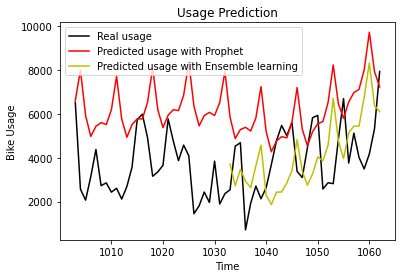

In [57]:

# plt.plot(y_true[0:30],c="b")
# plt.plot(prophet_forecast["yhat"][0:30], c="y")
# # plt.plot(ensemble[0:30], c="r")
plt.plot(day_result_new['started_at'][-60:],c='black',label = 'Real usage')
plt.plot(prophet_history['yhat'][-60:],color = 'red', label = 'Predicted usage with Prophet')
plt.plot(ensemble,c="y",label = 'Predicted usage with Ensemble learning')

plt.title('Usage Prediction')
plt.xlabel('Time')
plt.ylabel('Bike Usage')
plt.legend()
plt.savefig('day-lstm.png', 
                          dpi=600,
                          facecolor='w',
                          edgecolor='w',
                          orientation='portrait',
                          papertype=None, 
                          format=None,
                          transparent=False,
                          bbox_inches=None, 
                          pad_inches=0.1,
                          frameon=None, 
                          metadata=None)

#### Hour Data Moving Window

In [132]:
hourly_data=pd.read_csv("filled_hourly_agg.csv",parse_dates=["day-hour-time"],index_col=[0])
hourly_data=hourly_data.reset_index()
hourly_data['day-hour-time']=pd.to_datetime(hourly_data['day-hour-time'])
hourly_data=hourly_data.reset_index()
hourly_data['day-hour-time']=pd.to_datetime(hourly_data['day-hour-time'])
df=hourly_data

In [133]:
df=df.loc[df['day-hour-time']>=pd.to_datetime('2019-07-01')]
df=df.loc[df['day-hour-time']<pd.to_datetime('2019-09-01')]
df=df[['day-hour-time','started_at']]
df_for_training=pd.DataFrame(df['started_at'][:-7*24])

In [134]:
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
#df_for_testing_scaled=scaler.transform(df_for_testing)
df_for_training_scaled
timesteps=7*24
predict_steps=24
trainx, trainy = create_dataset(df_for_training_scaled, timesteps, predict_steps)
trainx = np.array(trainx)
trainy = np.array(trainy)
trainx = np.reshape(trainx,(trainx.shape[0],timesteps,1))
#lstm training
model = Sequential()
model.add(LSTM(128,input_shape=(timesteps,1),return_sequences= True)) #记得调整timestemp
model.add(Dropout(0.5))
model.add(LSTM(128,return_sequences=True))
#model.add(Dropout(0.3))
model.add(LSTM(64,return_sequences=False))
#model.add(Dropout(0.2))
model.add(Dense(predict_steps))  #这是预测输出层
model.compile(loss="mean_squared_error",optimizer="adam")
model.fit(trainx,trainy, epochs= 150, batch_size=200)



Epoch 1/150
6/6 [==============================] - 9s 852ms/step - loss: 0.0973
Epoch 2/150
6/6 [==============================] - 5s 817ms/step - loss: 0.0563
Epoch 3/150
6/6 [==============================] - 5s 852ms/step - loss: 0.0491
Epoch 4/150
6/6 [==============================] - 5s 790ms/step - loss: 0.0476
Epoch 5/150
6/6 [==============================] - 5s 780ms/step - loss: 0.0461
Epoch 6/150
6/6 [==============================] - 5s 798ms/step - loss: 0.0444
Epoch 7/150
6/6 [==============================] - 5s 809ms/step - loss: 0.0405
Epoch 8/150
6/6 [==============================] - 6s 998ms/step - loss: 0.0345
Epoch 9/150
6/6 [==============================] - 6s 1s/step - loss: 0.0282
Epoch 10/150
6/6 [==============================] - 7s 1s/step - loss: 0.0242
Epoch 11/150
6/6 [==============================] - 7s 1s/step - loss: 0.0230
Epoch 12/150
6/6 [==============================] - 7s 1s/step - loss: 0.0219
Epoch 13/150
6/6 [==============================]

In [135]:
length=7*24 #预测7天
predict_xlist = []#添加预测x列表
predict_y = []#添加预测y列表
predict_xlist.extend(df_for_training_scaled[df_for_training_scaled.shape[0]-timesteps:df_for_training_scaled.shape[0],0].tolist())#已经存在的最后timesteps个数据添加进列表，预测新值(比如已经有的数据从1,2,3到288。现在要预测后面的数据，所以将216到288的72个数据添加到列表中，预测新的值即288以后的数据）
while len(predict_y) < length:
    predictx = np.array(predict_xlist[-timesteps:])#从最新的predict_xlist取出timesteps个数据，预测新的predict_steps个数据（因为每次预测的y会添加到predict_xlist列表中，为了预测将来的值，所以每次构造的x要取这个列表中最后的timesteps个数据词啊性）
    predictx = np.reshape(predictx,(1,timesteps,1))#变换格式，适应LSTM模型
    #print("predictx"),print(predictx),print(predictx.shape)
    #预测新值
    lstm_predict = model.predict(predictx)
    #predict_list.append(train_predict)#新值y添加进列表，做x
    #滚动预测
    #print("lstm_predict"),print(lstm_predict[0])
    predict_xlist.extend(lstm_predict[0])#将新预测出来的predict_steps个数据，加入predict_xlist列表，用于下次预测
    # invert
    lstm_predict = scaler.inverse_transform(lstm_predict)
    predict_y.extend(lstm_predict[0])#预测的结果y，每次预测的12个数据，添加进去，直到预测288个为止
    #print("xlist", predict_xlist, len(predict_xlist))
    #print(lstm_predict, len(lstm_predict))
    #print(predict_y, len(predict_y))

1/1 [==============================] - 0s 38ms/step


In [136]:
ml_y=pd.DataFrame(predict_y[:7*24],index=df['started_at'][-7*24:].index)

/var/folders/p0/kb961x5d6wd79gfp2h6t_8500000gn/T/ipykernel_56172/4050122077.py:12: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('day-lstm.png',
/var/folders/p0/kb961x5d6wd79gfp2h6t_8500000gn/T/ipykernel_56172/4050122077.py:12: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('day-lstm.png',


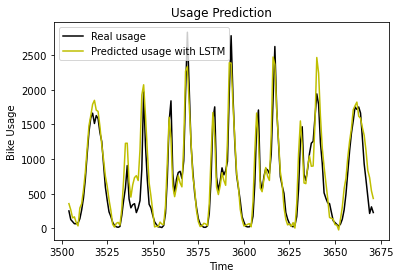

In [137]:

# plt.plot(y_true[0:30],c="b")
# plt.plot(prophet_forecast["yhat"][0:30], c="y")
# # plt.plot(ensemble[0:30], c="r")
plt.plot(df['started_at'][-7*24:],c='black',label = 'Real usage')
# plt.plot(forecast['yhat'][-7*24:-6*24],color = 'green', label = 'Predicted usage with Prophet')
plt.plot(ml_y,c="y",label = 'Predicted usage with LSTM')

plt.title('Usage Prediction')
plt.xlabel('Time')
plt.ylabel('Bike Usage')
plt.legend()
plt.savefig('hour-lstm.png', 
                          dpi=600,
                          facecolor='w',
                          edgecolor='w',
                          orientation='portrait',
                          papertype=None, 
                          format=None,
                          transparent=False,
                          bbox_inches=None, 
                          pad_inches=0.1,
                          frameon=None, 
                          metadata=None)